In [1]:
import sys
from pathlib import Path 
sys.path.append(str(Path.cwd().parent.parent))
import numpy as np
from kymatio.scattering2d.core.scattering2d import scattering2d
import matplotlib.pyplot as plt
import torch
import torchvision
from kymatio import Scattering2D
from PIL import Image
from IPython.display import display 
from torchvision.transforms import *

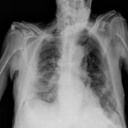

In [2]:
#img = Image.open('/NOBACKUP/gauthiers/KTH/sample_a/wood/54a-scale_10_im_10_col.png')
img = Image.open('/NOBACKUP/gauthiers/chest_xrays_preprocess/train/positive/MIDRC-RICORD-1C-SITE2-000216-21074-0.png')
rsz_transf = torchvision.transforms.Resize((128,128))
img = rsz_transf(img)
display(img)

Rotation

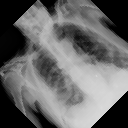

In [3]:
transformation = torchvision.transforms.RandomRotation(degrees = 45)
transformation.degrees = [45,45]
img_rot2 = transformation(img)
display(img_rot2)

Blur

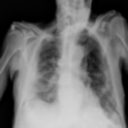

In [4]:
transformation = torchvision.transforms.GaussianBlur(3)
img_blur = transformation(img)
display(img_blur)

Perspective

/home/alseneracil/.conda/envs/parametricSN/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


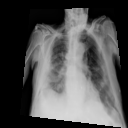

In [5]:
transformation = torchvision.transforms.RandomPerspective()
img_rdmPersp = transformation(img)
display(img_rdmPersp)

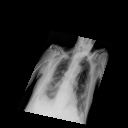

In [18]:
transforms = torchvision.transforms.RandomPerspective(distortion_scale=0.5,p=1)
transforms.distortion_scale = 0.9
img_1 = transforms(img)
display(img_1)


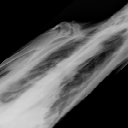

In [7]:
transforms = torchvision.transforms.RandomAffine(degrees = 0, shear=90)
img_2 = transforms(img)
display(img_2)


À la Mallat

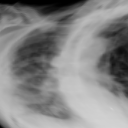

TypeError: <lambda>() takes 1 positional argument but 16384 were given

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
import time
t0 = time.time()
# Function \tau in Mallat's. Deform the index u. The function is chosen arbitrary as an example.
tau = lambda u : (0.5*u[0]+0.3*u[1]**2,0.3*u[1])
# Deform the index u for all u of the image.
tau_mat = lambda grid : torch.tensor([[tau(grid[i,j,:]) for j in range(len(grid))] for i in range(len(grid))],device = device)
tauV = lambda u : torch.stack([0.5*u[:,0]+0.3*u[:,1]**2,0.3*u[:,1]]).T


# Deforms the image given a function \tau.
def diffeo(img,tau):
    # Image to tensor
    transf = torchvision.transforms.ToTensor()
    img = transf(img).unsqueeze(0).to(device)
    # Number of pixels. Suppose square image.
    dim = img.shape[-1]
    # Create a (dim x dim) matrix of 2d vectors. Each vector represents the normalized position in the grid. 
    # Normalized means (-1,-1) is top left and (1,1) is bottom right.
    grid = torch.tensor([[[x,y] for x in torch.linspace(-1,1,dim,device = device)] for y in torch.linspace(-1,1,dim,device = device)],device = device)
    # Apply u-tau(u) in Mallat's. 
    grid_transf = (grid - tau_mat(grid)).unsqueeze(0)
    # Apply x(u-tau(u)) by interpolating the image at the index points given by grid_transf.
    img_transf = torch.nn.functional.grid_sample(img,grid_transf).squeeze(0)
    # Tensor to image
    transf = torchvision.transforms.ToPILImage()
    return transf(img_transf)

# Calculate the deformation size : sup |J_{tau}(u)| over u.
def deformation_size(tau):
    # Set a precision. This is arbitrary.
    precision = 128
    # Create a (flatten) grid of points between (-1,-1) and (1,1). This is the same grid as in the previous
    # function (but flatten), but it feels arbitrary also.
    points = [torch.tensor([x,y],device = device) for x in torch.linspace(-1,1,precision,device = device) for y in torch.linspace(-1,1,precision,device = device)]
    # Evaluate the Jacobian of tau in each of those points. Returns a tensor of precision^2 x 2 x 2, i.e.
    # for each point in points the 2 x 2 jacobian. Is it necessary to compute on all points, or only on the
    # boundary would be sufficient?
    t1 = time.time()
    jac = torch.stack(list(map(lambda point : torch.stack(torch.autograd.functional.jacobian(tau,point)), points)))
    print("grad calc +", (time.time()-t1))
    # Find the norm of those jacobians.
    norm_jac = torch.linalg.matrix_norm(jac,ord=2,dim=(1, 2))
    # Return the Jacobian with the biggest norm.
    return torch.max(norm_jac)

img_diffeo = diffeo(img,tau)
display(img_diffeo)
deformation_size(tau)
print("full notebook +", (time.time()-t0))

In [65]:
tau(torch.randn((64,2)))

(tensor([0.7630, 0.0519]), tensor([ 0.3611, -0.3974]))

In [59]:
points = [torch.tensor([0.,0.]),torch.tensor([1.,2.])]
jac = torch.autograd.functional.jacobian(tau,points[0])
jac2 = torch.stack(jac)
jac = torch.autograd.functional.jacobian(tau,points[1])
jac3 = torch.stack(jac)
n = 0
jac4 = torch.cat([jac2.unsqueeze(n),jac3.unsqueeze(n)],dim = n)
print(jac2)
print(jac3)
print(jac4)
print(jac4.shape)

jac5 = torch.cat([torch.stack(torch.autograd.functional.jacobian(tau,point)).unsqueeze(0) for point in points], dim = 0)
print(jac5)

tensor([[0.5000, 0.0000],
        [0.0000, 0.3000]])
tensor([[0.5000, 1.2000],
        [0.0000, 0.3000]])
tensor([[[0.5000, 0.0000],
         [0.0000, 0.3000]],

        [[0.5000, 1.2000],
         [0.0000, 0.3000]]])
torch.Size([2, 2, 2])
tensor([[[0.5000, 0.0000],
         [0.0000, 0.3000]],

        [[0.5000, 1.2000],
         [0.0000, 0.3000]]])


In [36]:
points = [torch.tensor([0.,0.]),torch.tensor([1.,2.])]
jac = torch.stack(list(map(lambda point : torch.stack(torch.autograd.functional.jacobian(tau,point)), points)))
print(jac)
print(jac.shape)

tensor([[[0.5000, 0.0000],
         [0.0000, 0.3000]],

        [[0.5000, 1.2000],
         [0.0000, 0.3000]]])
torch.Size([2, 2, 2])


In [47]:
points = [torch.tensor([0.,0.]),torch.tensor([1.,2.])]
jac = torch.cat([torch.cat([x.unsqueeze(1) for x in torch.autograd.functional.jacobian(tau,point)],dim =1).unsqueeze(2) for point in points],dim = 2)
print(jac)
print(jac.shape)

tensor([[[0.5000, 0.5000],
         [0.0000, 0.0000]],

        [[0.0000, 1.2000],
         [0.3000, 0.3000]]])
torch.Size([2, 2, 2])


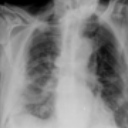

In [9]:
eps = 0.3
tau = lambda u : (eps*u[0],eps*u[1])
display(diffeo(img,tau))

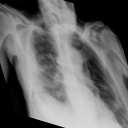

In [10]:
eps = 0.3
tau = lambda u : (eps*u[1],eps*u[0])
display(diffeo(img,tau))

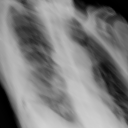

In [11]:
eps = 0.3
tau = lambda u : (eps*(u[0]+u[1]),eps*(u[0]+u[1]))
display(diffeo(img,tau))

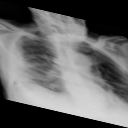

In [12]:
eps = 0.3
tau = lambda u : (eps*(u[0]+u[1]),eps*(u[0]-u[1]))
display(diffeo(img,tau))

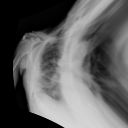

In [13]:
eps = 0.3
tau = lambda u : (eps*(u[0]**2+u[1]**2),eps*(2*u[0]*u[1]))
display(diffeo(img,tau))

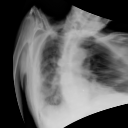

In [14]:
eps = 0.3
tau = lambda u : (eps*(u[0]**2+u[1]**2),-eps*(2*u[0]*u[1]))
display(diffeo(img,tau))

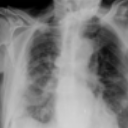

In [15]:
eps = 0.3
tau = lambda u : (torch.exp(eps*u[0])-1,torch.exp(eps*u[1])-1)
display(diffeo(img,tau))